# Version 2 – Hệ thống chấm điểm
## Mô tả
Hệ thống đã có thể chấm điểm dựa trên ảnh đầu vào.  
Quy trình bao gồm:
- Warp ảnh về tọa độ chuẩn để chuẩn hóa vị trí các ô trả lời và cắt các cell tính toán.
- Truyền file JSON đáp án (answer.json) và file JSON thông tin sinh viên (student_coords.json).
- Đọc mã dự thi, mã đề và câu trả lời của học sinh.
- So sánh với đáp án đúng và tính điểm, xuất kết quả chi tiết theo từng câu.

## Thay đổi so với version 1
- Chủ yếu sử dụng Timing Marks để xác định vị trí đáp án thay cho việc xác định vị trí cắt cell thủ công
- Tuy nhiên phần mã đề và mã dự thi chưa có các mark theo chiều ngang cho cột nên vẫn thủ công 1 phần

## Hạn chế
- Chưa xử lý tốt cho ảnh chụp thực tế, đặc biệt khi giấy đặt trên bề mặc không phẳng, gây méo, lồi lõm.
- Hàm xác định fill circle (vị trí tô) còn sơ sài, chưa thể nhận diện chính xác tất cả các loại ảnh chụp.
- Hiện tại chỉ phù hợp với ảnh scan hoặc ảnh chụp trên bề mặt phẳng.


# Import Libs & Image

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('E:/WorkSpace/Agent/Teaching Assistant/Grader/kaggle/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from PIL import Image
from IPython.display import display
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import json

In [3]:
import os
from pathlib import Path

# Get dynamic paths based on notebook location
notebook_dir = Path(os.getcwd())
project_root = notebook_dir.parent if notebook_dir.name == 'kaggle' else notebook_dir

# Setup directories
input_materials_dir = notebook_dir / "Input Materials" if (notebook_dir / "Input Materials").exists() else project_root / "kaggle" / "Input Materials"

# JSON file paths
student_json_path = str(input_materials_dir / "student_coords.json")
answer_json_path = str(input_materials_dir / "answer.json")

print(f"Student JSON: {student_json_path}")
print(f"Answer JSON: {answer_json_path}")


Student JSON: E:\WorkSpace\Agent\Teaching Assistant\Grader\kaggle\Input Materials\student_coords.json
Answer JSON: E:\WorkSpace\Agent\Teaching Assistant\Grader\kaggle\Input Materials\answer.json


In [4]:
import glob
from pathlib import Path
import os

# Get dynamic paths (reuse from cell 5)
notebook_dir = Path(os.getcwd())
project_root = notebook_dir.parent if notebook_dir.name == 'kaggle' else notebook_dir

# Paths
template_dir = notebook_dir / "Template" if (notebook_dir / "Template").exists() else project_root / "kaggle" / "Template"
filled_temp_dir = notebook_dir / "Filled-temp" if (notebook_dir / "Filled-temp").exists() else project_root / "kaggle" / "Filled-temp"

print(f"Project root: {project_root}")
print(f"Template dir: {template_dir}")
print(f"Filled-temp dir: {filled_temp_dir}")

# Load template image (required)
template_path = template_dir / "temp.jpg"
img_temp = cv2.imread(str(template_path), cv2.IMREAD_GRAYSCALE)
if img_temp is None:
    raise FileNotFoundError(f"Không tìm thấy template image tại {template_path}")
print(f"Đã load template image")

# Auto-discover all images in Filled-temp folder
filled_temp_dir.mkdir(parents=True, exist_ok=True)

# Find all image files
image_files = list(filled_temp_dir.glob("*.jpg")) + list(filled_temp_dir.glob("*.jpeg")) + \
              list(filled_temp_dir.glob("*.png")) + list(filled_temp_dir.glob("*.JPG"))

if not image_files:
    print("Cảnh báo: Không tìm thấy ảnh nào trong thư mục Filled-temp/")
    print("Vui lòng upload ảnh bài thi vào thư mục này trước khi chạy notebook.")
    imgs_to_grade = {}
else:
    print(f"\nTìm thấy {len(image_files)} ảnh trong Filled-temp:")
    imgs_to_grade = {}
    for img_path in image_files:
        img_name = img_path.stem
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            imgs_to_grade[img_name] = img
            print(f"   - {img_path.name}")
        else:
            print(f"   Không thể đọc: {img_path.name}")

print(f"\n Tổng số ảnh đã load thành công: {len(imgs_to_grade)}")

# Load first image for demo/testing of functions
if imgs_to_grade:
    first_img_name = list(imgs_to_grade.keys())[0]
    img_test2 = imgs_to_grade[first_img_name]
    print(f" Sử dụng ảnh '{first_img_name}' làm mẫu test cho các cell demo")


Project root: E:\WorkSpace\Agent\Teaching Assistant\Grader
Template dir: E:\WorkSpace\Agent\Teaching Assistant\Grader\kaggle\Template
Filled-temp dir: E:\WorkSpace\Agent\Teaching Assistant\Grader\kaggle\Filled-temp
Đã load template image

Tìm thấy 2 ảnh trong Filled-temp:
   - test2.jpg
   - test2.jpg

 Tổng số ảnh đã load thành công: 1
 Sử dụng ảnh 'test2' làm mẫu test cho các cell demo


# Warp ảnh về cùng tọa độ và kích thước với template

### Hàm Denoise, Enhance, Sharpen trước khi warp

In [5]:
# denoise + enhance + sharpen
def denoise_enhance_sharpen(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape)==3 else img

    den = cv2.fastNlMeansDenoising(gray, None, h=10, templateWindowSize=7, searchWindowSize=21)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(den)

    blur = cv2.GaussianBlur(enhanced, (3,3), 0)
    sharpened = cv2.addWeighted(enhanced, 1.5, blur, -0.5, 0)

    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
    
    return sharpened

### Hàm Warp

In [6]:
def warp_to_template(img_proc, template_kp, template_des, template_img):
    kp, des = sift.detectAndCompute(img_proc, None)
    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.knnMatch(template_des, des, k=2)
    
    good_matches = [m for m,n in matches if m.distance < 0.75*n.distance]
    
    if len(good_matches) < 4:
        raise ValueError("Không đủ điểm match để tính Homography")
    
    pts_template = np.float32([template_kp[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    pts_img = np.float32([kp[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
    
    H, mask = cv2.findHomography(pts_img, pts_template, cv2.RANSAC, 5.0)
    
    h, w = template_img.shape[:2]
    warped = cv2.warpPerspective(img_proc, H, (w, h))
    return warped

### Warp ảnh sử dụng SIFT detect feature trên template

In [7]:
# ====== CODE CŨ - ĐÃ VÔ HIỆU HÓA ======
# Cell này xử lý các ảnh case1, case2, case3, photo2 đã hardcode
# Bây giờ sử dụng dynamic processing

print(" Cell đã bị vô hiệu hóa. Xử lý ảnh được thực hiện tự động.")

# Preprocess template for later use
img_temp_proc = denoise_enhance_sharpen(img_temp)

# Detect SIFT features on template
sift = cv2.SIFT_create(nfeatures=5000)
kp_temp, des_temp = sift.detectAndCompute(img_temp_proc, None)
print(f" Đã detect {len(kp_temp)} SIFT features trên template")

# Preprocess and warp test image if available (for demo)
if 'img_test2' in globals():
    img_test2_proc = denoise_enhance_sharpen(img_test2)
    warped_test2 = warp_to_template(img_test2_proc, kp_temp, des_temp, img_temp_proc)
    print(f" Đã warp ảnh test '{first_img_name}' thành công (dùng cho demo)")


 Cell đã bị vô hiệu hóa. Xử lý ảnh được thực hiện tự động.


 Đã detect 5000 SIFT features trên template


 Đã warp ảnh test 'test2' thành công (dùng cho demo)


# Xử lý cắt cell cho vùng tô đáp án

### Hàm xác định các timing marks hoặc các dấu đen trên dải ảnh - strips để làm căn chỉnh vị trí hàng/cột

In [8]:
def detect_marks(binary_strip, axis='vertical', 
                 min_area=50, max_area=8000,
                 min_dist=8,
                 aspect_ratio_range=(0.2, 6.0),
                 edge_margin=3,
                 debug=False):
    h, w = binary_strip.shape[:2]
    contours, _ = cv2.findContours(binary_strip, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidates = []
    vis_debug = cv2.cvtColor(binary_strip, cv2.COLOR_GRAY2BGR)
    for cnt in contours:
        x, y, w_box, h_box = cv2.boundingRect(cnt)
        area = w_box * h_box
        if area < min_area or area > max_area:
            continue
        aspect = w_box / h_box if h_box > 0 else 0
        if not (aspect_ratio_range[0] <= aspect <= aspect_ratio_range[1]):
            continue
        if axis == 'vertical':
            if x < edge_margin or x + w_box > w - edge_margin:
                continue
            pos = y + h_box // 2
        else:
            if y < edge_margin or y + h_box > h - edge_margin:
                continue
            pos = x + w_box // 2
        candidates.append((pos, area))
        if debug:
            cv2.rectangle(vis_debug, (x, y), (x + w_box, y + h_box), (0, 255, 0), 1)
    candidates.sort(key=lambda x: x[0])
    filtered = []
    for pos, area in candidates:
        if not filtered or abs(pos - filtered[-1]) >= min_dist:
            filtered.append(pos)
    if debug:
        plt.figure(figsize=(10, 4))
        plt.imshow(vis_debug)
        plt.title(f"DEBUG {axis}: {len(filtered)} marks / {len(contours)} contours")
        plt.axis('off')
        plt.show()
    return filtered


### Hàm xử lý dải timing marks (dọc/phải, ngang/dưới) để chuẩn bị cho việc phát hiện timing marks

In [9]:
def extract_timing_marks(warped_img, right_ratio=0.05, bottom_ratio=0.05, overlap_pad=20):
    h, w = warped_img.shape[:2]
    right_start_x = int(w * (1 - right_ratio))
    right_strip = warped_img[:, right_start_x:]
    bottom_start_y = int(h * (1 - bottom_ratio))
    bottom_strip = warped_img[bottom_start_y:, :]
    return right_strip, bottom_strip

def preprocess_strip(strip, enhance=True):
    gray = cv2.cvtColor(strip, cv2.COLOR_BGR2GRAY) if len(strip.shape)==3 else strip
    if enhance:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray = clahe.apply(gray)
    gray = cv2.GaussianBlur(gray, (3,3), 0)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    return binary

### Hàm trực quan hóa

In [10]:
def visualize_detection(warped_img, right_strip, bottom_strip, bin_right, bin_bottom):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes[0,0].imshow(right_strip, cmap='gray')
    axes[0,0].set_title("Right Strip (Original)")
    axes[0,1].imshow(bin_right, cmap='gray')
    axes[0,1].set_title("Right Strip (Binary)")
    axes[1,0].imshow(bottom_strip, cmap='gray')
    axes[1,0].set_title("Bottom Strip (Original)")
    axes[1,1].imshow(bin_bottom, cmap='gray')
    axes[1,1].set_title("Bottom Strip (Binary)")
    plt.tight_layout()
    plt.show()


### Hàm xác định cell cắt các ô đáp án

In [11]:
def extract_answer_cells(warped_img, row_marks, col_marks, cell_size=20):
    vis = warped_img.copy()
    if len(vis.shape) == 2:
        vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)
    cells = []
    for y in row_marks:
        for x in col_marks:
            y1, y2 = int(y - cell_size), int(y + cell_size)
            x1, x2 = int(x - cell_size), int(x + cell_size)
            cell = warped_img[max(0,y1):min(warped_img.shape[0],y2),
                              max(0,x1):min(warped_img.shape[1],x2)]
            cells.append(cell)
            cv2.rectangle(vis, (x1, y1), (x2, y2), (0,255,0), 1)
    return vis, cells


In [12]:
right_strip, bottom_strip = extract_timing_marks(warped_test2)
bin_right = preprocess_strip(right_strip, enhance=True)
bin_bottom = preprocess_strip(bottom_strip, enhance=True)

In [13]:
row_marks = detect_marks(bin_right, axis='vertical', min_area=150, min_dist=10)
col_marks = detect_marks(bin_bottom, axis='horizontal', min_area=150, min_dist=10)
print(f"Số marks theo hàng: {len(row_marks)}")
print(f"Số marks theo cột: {len(col_marks)}")

Số marks theo hàng: 42
Số marks theo cột: 18


### VẼ GRID LINES

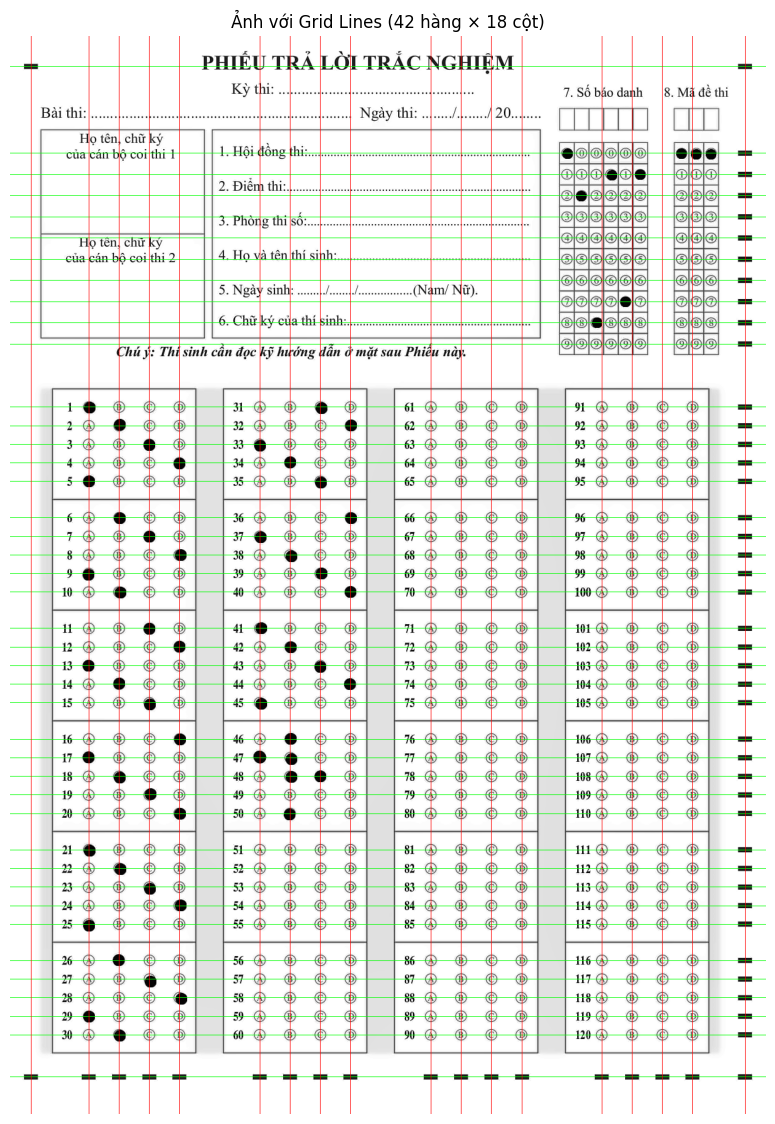

In [14]:
vis_grid = warped_test2.copy()
if len(vis_grid.shape) == 2:
    vis_grid = cv2.cvtColor(vis_grid, cv2.COLOR_GRAY2BGR)

for y in row_marks:
    cv2.line(vis_grid, (0, y), (vis_grid.shape[1], y), (0, 255, 0), 1)
for x in col_marks:
    cv2.line(vis_grid, (x, 0), (x, vis_grid.shape[0]), (255, 0, 0), 1)

plt.figure(figsize=(12, 14))
plt.imshow(vis_grid)
plt.title(f"Ảnh với Grid Lines ({len(row_marks)} hàng × {len(col_marks)} cột)")
plt.axis('off')
plt.show()

### VẼ Ô CELLS

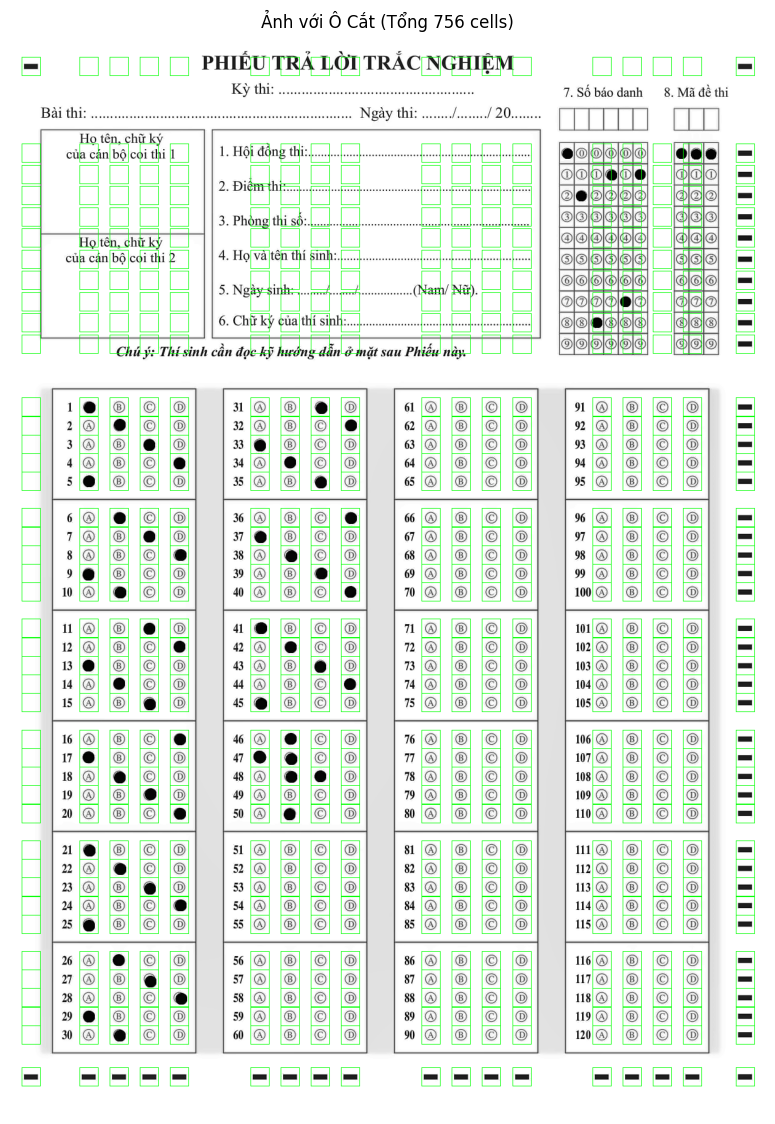

In [15]:
vis_cells, cells = extract_answer_cells(warped_test2, row_marks, col_marks, cell_size=15)

plt.figure(figsize=(12, 14))
plt.imshow(vis_cells)
plt.title(f"Ảnh với Ô Cắt (Tổng {len(cells)} cells)")
plt.axis('off')
plt.show()

#### Ta chỉ quan tâm đến vùng đáp án

### Đánh index các ô đã cắt ra từ cells theo tọa độ row_marks và col_marks và hiển thị trực quan

In [16]:
def index_and_save_cells(cells, row_marks, col_marks, save_dir="cells_output", save=False):
    os.makedirs(save_dir, exist_ok=True)
    
    num_rows = len(row_marks)
    num_cols = len(col_marks)
    print(f"Tổng ô: {len(cells)} ({num_rows} hàng × {num_cols} cột)")

    # Tạo ảnh hiển thị grid có chỉ số
    vis_index = warped_test2.copy()
    if len(vis_index.shape) == 2:
        vis_index = cv2.cvtColor(vis_index, cv2.COLOR_GRAY2BGR)

    cell_index = 0
    for i, y in enumerate(row_marks):
        for j, x in enumerate(col_marks):
            y1, y2 = int(y - 15), int(y + 15)
            x1, x2 = int(x - 15), int(x + 15)
            
            # Ghi index lên ảnh
            cv2.putText(vis_index, f"{i},{j}", (x1+2, y1+12),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1, cv2.LINE_AA)
            
            if save:
                # Lưu ô với tên "r{i}_c{j}.png"
                filename = os.path.join(save_dir, f"r{i:02d}_c{j:02d}.png")
                cv2.imwrite(filename, cells[cell_index])
            
            cell_index += 1

    plt.figure(figsize=(12, 14))
    plt.imshow(vis_index)
    plt.title("Ảnh với Index từng Ô (hàng, cột)")
    plt.axis('off')
    plt.show()


Tổng ô: 756 (42 hàng × 18 cột)


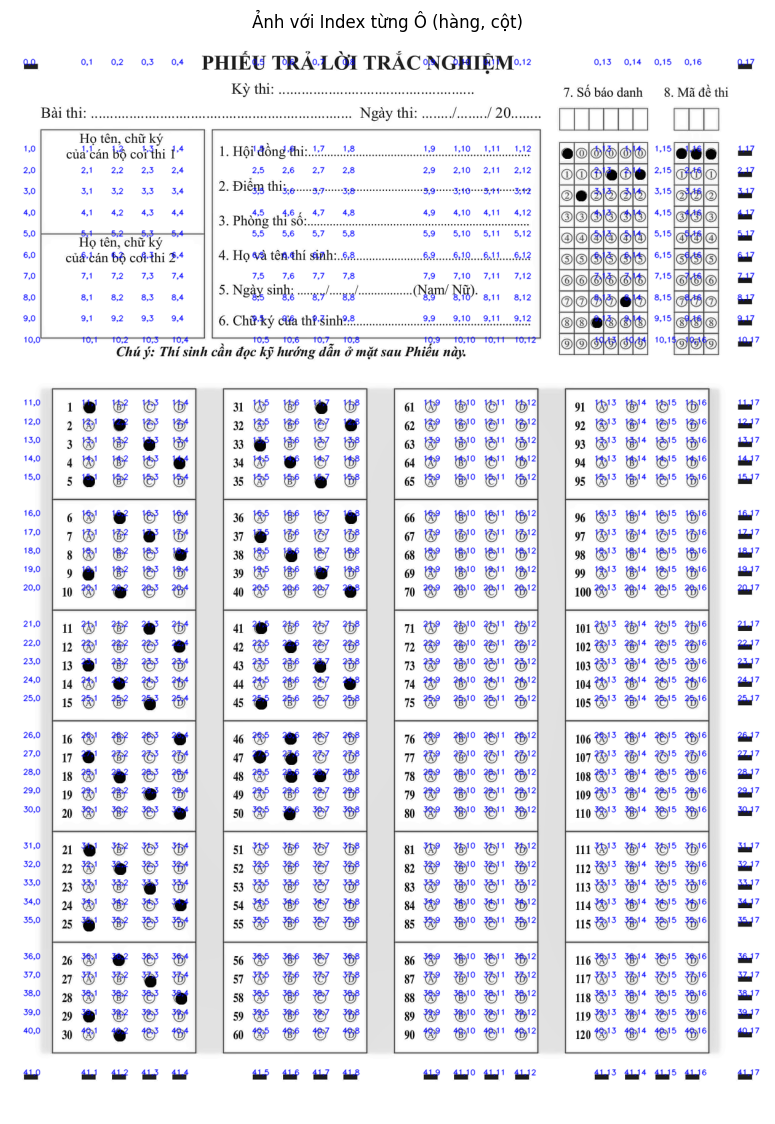

In [17]:
index_and_save_cells(cells, row_marks, col_marks, save_dir="cells_output", save=False)

### Chuyển list cells (đã cắt theo thứ tự hàng-cột) thành mảng 2D [row][col]
### Lấy 4 ô (A, B, C, D) tương ứng với 1 câu hỏi (q_idx: 1..120)

In [18]:
def map_answer_cells(cells, n_rows=42, n_cols=18):
    """Map cells to 2D array with validation"""
    required_cells = n_rows * n_cols
    if len(cells) < required_cells:
        raise ValueError(
            f"Không đủ cells để map! Cần {required_cells} cells nhưng chỉ có {len(cells)}. "
            f"Nguyên nhân: Ảnh chụp không rõ, timing marks không đủ, hoặc ảnh bị nghiêng."
        )
    
    mapped = []
    idx = 0
    for r in range(n_rows):
        row_cells = []
        for c in range(n_cols):
            row_cells.append(cells[idx])
            idx += 1
        mapped.append(row_cells)
    return mapped


def get_question_cells(mapped, q_idx):

    col_block = (q_idx - 1) // 30  
    in_block_idx = (q_idx - 1) % 30

    row = 11 + in_block_idx  
    col_start = 1 + col_block * 4 
    col_end = col_start + 4

    answer_cells = mapped[row][col_start:col_end]
    return answer_cells




In [19]:


# img_temp_proc = denoise_enhance_sharpen(img_temp)
# img_case1_proc = denoise_enhance_sharpen(img_case1)
# img_case2_proc = denoise_enhance_sharpen(img_case2)
# img_case3_proc = denoise_enhance_sharpen(img_case3)
# img_test_proc = denoise_enhance_sharpen(img_test)
# img_test2_proc = denoise_enhance_sharpen(img_test2)

print(" Cell đã bị vô hiệu hóa. Xử lý ảnh được thực hiện trong auto-processing loop.")

# Preprocess template for later use
img_temp_proc = denoise_enhance_sharpen(img_temp)

# Preprocess test image if available
if 'img_test2' in globals():
    img_test2_proc = denoise_enhance_sharpen(img_test2)


 Cell đã bị vô hiệu hóa. Xử lý ảnh được thực hiện trong auto-processing loop.


In [20]:
def visualize_answer_region(mapped_cells):
    n_rows = 30 
    n_cols = 16 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 22))
    axes = np.array(axes)

    # r=0..29 -> hàng 11..40
    for r in range(n_rows):
        row_idx = r + 11
        # c=0..15 -> cột 1..16
        for c in range(n_cols):
            col_idx = c + 1
            cell = mapped_cells[row_idx][col_idx]
            
            col_block = (c // 4)   
            in_block_idx = r 
            q_idx = col_block * 30 + in_block_idx + 1
            opt = ["A","B","C","D"][c % 4]
            
            ax = axes[r, c]
            ax.imshow(cell, cmap='gray')
            ax.set_title(f"{q_idx}.{opt}", fontsize=6)
            ax.axis('off')

    plt.tight_layout()
    plt.show()


In [21]:
mapped_cells = map_answer_cells(cells, n_rows=42, n_cols=18)
# visualize_answer_region(mapped_cells)


# Xác định đáp án đã chọn

### Các hàm xác định ô đã tô cho từng câu hỏi trong phiếu trắc nghiệm

In [22]:
def binarize_cell(cell, threshold=128):
    gray = cell if len(cell.shape) == 2 else cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
    return binary

def is_cell_filled(cell, pixel_threshold=100):
    binary = binarize_cell(cell)
    count = cv2.countNonZero(binary)
    return count > pixel_threshold

def analyze_answers_from_mapped(mapped_cells, pixel_threshold=100):
    results = {}
    for q_idx in range(1, 121):
        answer_cells = get_question_cells(mapped_cells, q_idx)
        selected = []
        for i, cell in enumerate(answer_cells):
            if is_cell_filled(cell, pixel_threshold):
                selected.append(["A", "B", "C", "D"][i])
        results[q_idx] = selected  # có thể rỗng nếu chưa chọn
    return results


In [23]:
mapped = map_answer_cells(cells)
answers = analyze_answers_from_mapped(mapped_cells, pixel_threshold=100)

for q in range(1, 120):
    print(f"Câu {q}: {answers[q]}")


Câu 1: ['A']
Câu 2: ['B']
Câu 3: ['C']
Câu 4: ['D']
Câu 5: ['A']
Câu 6: ['B']
Câu 7: ['C']
Câu 8: ['D']
Câu 9: ['A']
Câu 10: ['B']
Câu 11: ['C']
Câu 12: ['D']
Câu 13: ['A']
Câu 14: ['B']
Câu 15: ['C']
Câu 16: ['D']
Câu 17: ['A']
Câu 18: ['B']
Câu 19: ['C']
Câu 20: ['D']
Câu 21: ['A']
Câu 22: ['B']
Câu 23: ['C']
Câu 24: ['D']
Câu 25: ['A']
Câu 26: ['B']
Câu 27: ['C']
Câu 28: ['D']
Câu 29: ['A']
Câu 30: ['B']
Câu 31: ['C']
Câu 32: ['D']
Câu 33: ['A']
Câu 34: ['B']
Câu 35: ['C']
Câu 36: ['D']
Câu 37: ['A']
Câu 38: ['B']
Câu 39: ['C']
Câu 40: ['D']
Câu 41: ['A']
Câu 42: ['B']
Câu 43: ['C']
Câu 44: ['D']
Câu 45: ['A']
Câu 46: ['B']
Câu 47: ['A', 'B']
Câu 48: ['B', 'C']
Câu 49: []
Câu 50: ['B']
Câu 51: []
Câu 52: []
Câu 53: []
Câu 54: []
Câu 55: []
Câu 56: []
Câu 57: []
Câu 58: []
Câu 59: []
Câu 60: []
Câu 61: []
Câu 62: []
Câu 63: []
Câu 64: []
Câu 65: []
Câu 66: []
Câu 67: []
Câu 68: []
Câu 69: []
Câu 70: []
Câu 71: []
Câu 72: []
Câu 73: []
Câu 74: []
Câu 75: []
Câu 76: []
Câu 77: []
Câu 7

# Xử lý cắt cell cho vùng mã dự thi và mã đề

### Hàm cắt các ô trong vùng mã dự thi / mã đề và vẽ trực quan index.

In [24]:
x0 = 892
x1 = 1080
row_h = 35
total_width0 = 145
total_width1 = 72
n_cols0= 6
n_cols1= 3

In [25]:
def crop_and_visualize_code_area(img, row_marks, x0, total_width, n_cols, row_height=35, save_dir=None):
    vis = img.copy()
    if len(vis.shape) == 2:
        vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)
    
    half_h = row_height // 2
    cell_w = total_width / n_cols
    blocks, block_indices = [], []

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    for row_idx, y_center in enumerate(row_marks):
        y1 = max(0, int(y_center - half_h))
        y2 = min(img.shape[0], int(y_center + half_h))
        for col_idx in range(n_cols):
            x1 = int(x0 + col_idx * cell_w)
            x2 = int(x0 + (col_idx + 1) * cell_w)
            x2 = min(img.shape[1], x2)
            if y2 <= y1 or x2 <= x1:
                continue
            block = img[y1:y2, x1:x2]
            blocks.append(block)
            block_indices.append((row_idx, col_idx))
            cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 1)
            cv2.putText(vis, f"{row_idx},{col_idx}", (x1+2, y1+12),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1, cv2.LINE_AA)
            if save_dir:
                cv2.imwrite(os.path.join(save_dir, f"r{row_idx:02d}_c{col_idx:02d}.png"), block)
    
    plt.figure(figsize=(12, 14))
    plt.imshow(vis)
    plt.title(f"Visualize Regions ({len(row_marks)} hàng × {n_cols} cột)")
    plt.axis('off')
    plt.show()
    
    return blocks, block_indices, vis

In [26]:
row_indices = range(1, 11)
selected_rows = [row_marks[i] for i in row_indices]

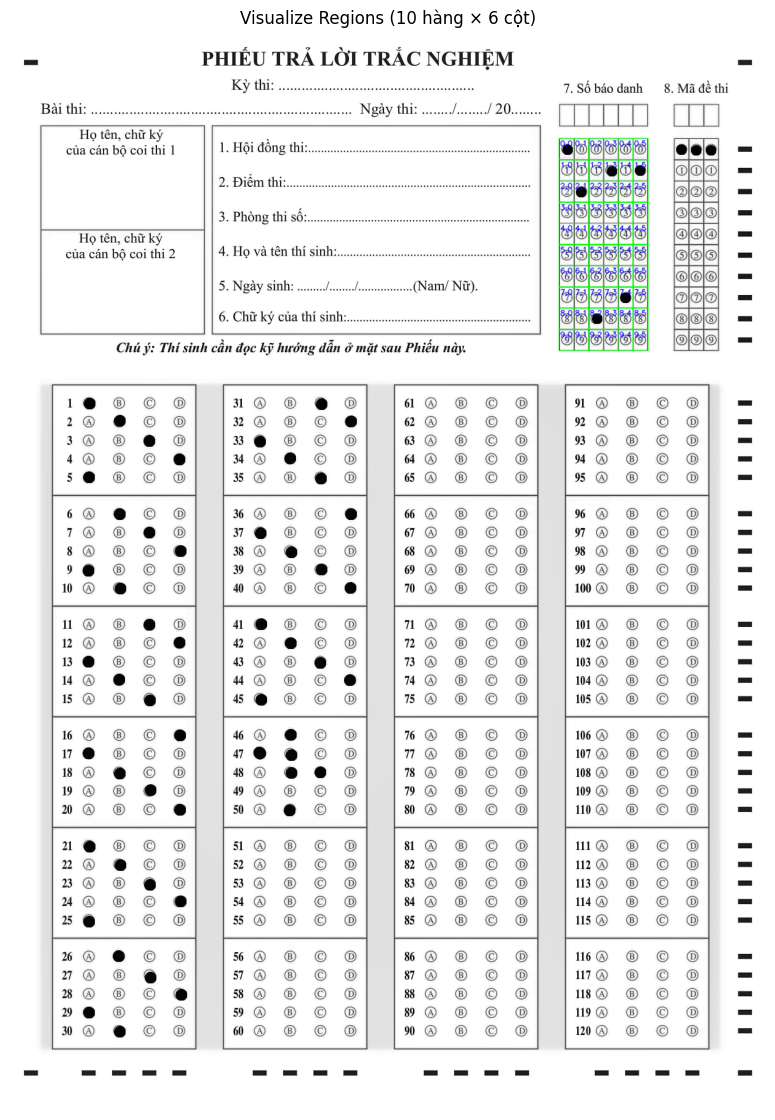

In [27]:
# Mã dự thi
blocks_student, indices_student, vis_student = crop_and_visualize_code_area(
    warped_test2, selected_rows, x0, total_width0, n_cols0, row_h
)


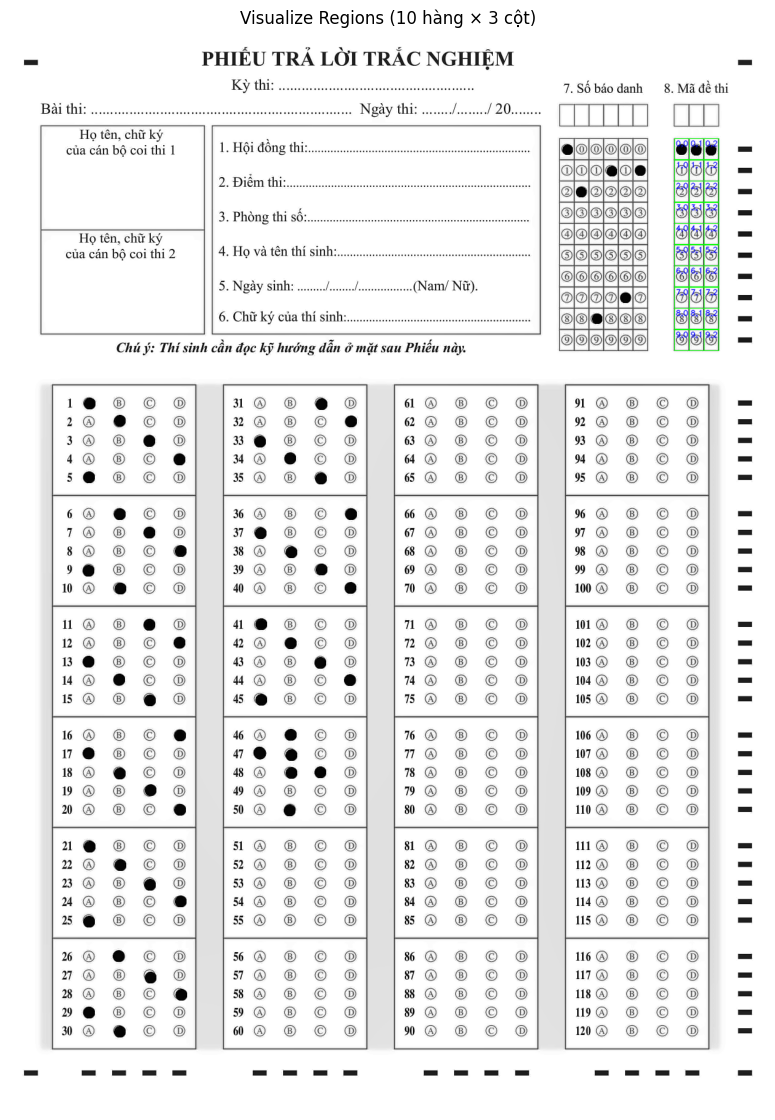

In [28]:
# Mã đề
blocks_exam, indices_exam, vis_exam = crop_and_visualize_code_area(
    warped_test2, selected_rows, x1, total_width1, n_cols1, row_h
)


### Các hàm hoàn chỉnh để nhận diện mã số trong các ô mã dự thi/mã đề

In [29]:
def preprocess_cell(cell):
    gray = cell if len(cell.shape) == 2 else cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]], dtype=np.float32)
    sharp = cv2.filter2D(gray, -1, kernel)
    return sharp

def binarize_cell_coords(cell, threshold=128):
    pre = preprocess_cell(cell)
    _, binary = cv2.threshold(pre, threshold, 255, cv2.THRESH_BINARY_INV)
    return binary

def get_fill_count(cell, threshold=128):
    binary = binarize_cell_coords(cell, threshold)
    return cv2.countNonZero(binary)

def predict_code_from_blocks(blocks, n_rows, n_cols, threshold=128):
    code = ""
    for col_idx in range(n_cols):
        col_cells = [blocks[row_idx * n_cols + col_idx] for row_idx in range(n_rows)]
        fill_counts = [get_fill_count(c, threshold) for c in col_cells]
        if max(fill_counts) == 0:
            code += "?"
        else:
            selected_row = int(np.argmax(fill_counts))
            code += str(selected_row % 10)
    return code




In [30]:
student_code = predict_code_from_blocks(blocks_student, n_rows=10, n_cols=6, threshold=100)
exam_code    = predict_code_from_blocks(blocks_exam, n_rows=10, n_cols=3, threshold=100)

print("Mã dự thi:", student_code)
print("Mã đề:", exam_code)

Mã dự thi: 028171
Mã đề: 000


# Tổng hợp và tính điểm

### Hàm tổng hợp kết quả Đáp án đã điền, mã dự thi, mã đề

In [31]:
def analyze_exam_results(blocks_student, blocks_exam, mapped_cells, 
                         n_rows_code=10, n_cols_student=6, n_cols_exam=3, 
                         pixel_threshold=100, bin_threshold=128):
    
    student_code = predict_code_from_blocks(blocks_student, n_rows=n_rows_code, n_cols=n_cols_student, threshold=pixel_threshold)
    
    exam_code = predict_code_from_blocks(blocks_exam, n_rows=n_rows_code, n_cols=n_cols_exam, threshold=pixel_threshold)
    
    answers = analyze_answers_from_mapped(mapped_cells, pixel_threshold=pixel_threshold)
    
    return {
        "student_code": student_code,
        "exam_code": exam_code,
        "answers": answers
    }

results = analyze_exam_results(
    blocks_student=blocks_student,
    blocks_exam=blocks_exam,
    mapped_cells=mapped
)


In [32]:
print("Mã dự thi:", results["student_code"])
print("Mã đề:", results["exam_code"])

for q in range(1, 121):
    print(f"Câu {q}: {results['answers'][q]}")

Mã dự thi: 028171
Mã đề: 000
Câu 1: ['A']
Câu 2: ['B']
Câu 3: ['C']
Câu 4: ['D']
Câu 5: ['A']
Câu 6: ['B']
Câu 7: ['C']
Câu 8: ['D']
Câu 9: ['A']
Câu 10: ['B']
Câu 11: ['C']
Câu 12: ['D']
Câu 13: ['A']
Câu 14: ['B']
Câu 15: ['C']
Câu 16: ['D']
Câu 17: ['A']
Câu 18: ['B']
Câu 19: ['C']
Câu 20: ['D']
Câu 21: ['A']
Câu 22: ['B']
Câu 23: ['C']
Câu 24: ['D']
Câu 25: ['A']
Câu 26: ['B']
Câu 27: ['C']
Câu 28: ['D']
Câu 29: ['A']
Câu 30: ['B']
Câu 31: ['C']
Câu 32: ['D']
Câu 33: ['A']
Câu 34: ['B']
Câu 35: ['C']
Câu 36: ['D']
Câu 37: ['A']
Câu 38: ['B']
Câu 39: ['C']
Câu 40: ['D']
Câu 41: ['A']
Câu 42: ['B']
Câu 43: ['C']
Câu 44: ['D']
Câu 45: ['A']
Câu 46: ['B']
Câu 47: ['A', 'B']
Câu 48: ['B', 'C']
Câu 49: []
Câu 50: ['B']
Câu 51: []
Câu 52: []
Câu 53: []
Câu 54: []
Câu 55: []
Câu 56: []
Câu 57: []
Câu 58: []
Câu 59: []
Câu 60: []
Câu 61: []
Câu 62: []
Câu 63: []
Câu 64: []
Câu 65: []
Câu 66: []
Câu 67: []
Câu 68: []
Câu 69: []
Câu 70: []
Câu 71: []
Câu 72: []
Câu 73: []
Câu 74: []
Câu 75: [

### Hàm chấm điểm

In [33]:
def grade_exam(result, student_json_path, answer_json_path, verbose=True):
    with open(student_json_path, "r", encoding="utf-8") as f:
        students = json.load(f)
    with open(answer_json_path, "r", encoding="utf-8") as f:
        answer_keys = json.load(f)

    student_code = result.get("student_code")
    exam_code = result.get("exam_code")
    answers_student = result.get("answers", {})

    student_info = next((s for s in students if s["coords"] == student_code), None)
    if not student_info:
        student_info = {"student_id": None, "name": "Unknown", "email": None}

    key = next((a for a in answer_keys if a["exam_code"] == exam_code), None)
    if not key:
        raise ValueError(f"Không tìm thấy đáp án cho mã đề {exam_code}")
    correct_answers = {item["question"]: item["answer"] for item in key["answers"]}
    total = len(correct_answers)

    correct = wrong = blank = 0
    detail = []

    for i in range(1, total + 1):
        ans = answers_student.get(i, [])
        student_choice = ans[0] if len(ans) == 1 else None

        if len(ans) == 0:
            blank += 1
            res = "blank"
        elif len(ans) > 1:
            wrong += 1
            res = "multi"
        elif student_choice == correct_answers.get(i):
            correct += 1
            res = "correct"
        else:
            wrong += 1
            res = "wrong"

        detail_item = {
            "question": i,
            "student_answer": None if len(ans) == 0 else ans if len(ans) > 1 else student_choice,
            "correct_answer": correct_answers.get(i),
            "result": res
        }
        detail.append(detail_item)

        if verbose:
            print(f"Câu {i}: Sinh viên chọn: {detail_item['student_answer']}, "
                  f"Đáp án đúng: {detail_item['correct_answer']}, "
                  f"Kết quả: {detail_item['result']}")

    score = round((correct / total) * 10, 2)

    return {
        "student_id": student_info.get("student_id"),
        "name": student_info.get("name"),
        "email": student_info.get("email"),
        "student_code": student_code,
        "exam_code": exam_code,
        "total_questions": total,
        "correct": correct,
        "wrong": wrong,
        "blank": blank,
        "score": score,
        "details": detail
    }



### Hàm in kết quả ví dụ

In [34]:
def print_exam_result(final_result):
    print("\n--- Chi tiết từng câu ---")
    for item in final_result.get("details", []):
        print(f"Câu {item['question']}: Sinh viên chọn: {item['student_answer']}, "
              f"Đáp án đúng: {item['correct_answer']}, "
              f"Kết quả: {item['result']}")

    print("\n--- Tổng kết ---")
    print("Mã dự thi:", final_result.get("student_code"))
    print("Mã đề:", final_result.get("exam_code"))
    print("Điểm:", final_result.get("score"))
    print("Đúng:", final_result.get("correct"),
          "Sai:", final_result.get("wrong"),
          "Bỏ trống:", final_result.get("blank"))

In [35]:


# final_result = grade_exam(
#     result=results,
#     student_json_path=student_json_path,
#     answer_json_path=answer_json_path,
#     verbose=False
# )

# print_exam_result(final_result)

print(" Cell này đã bị vô hiệu hóa. Chạy các cell ở dưới để xử lý tự động tất cả ảnh.")

 Cell này đã bị vô hiệu hóa. Chạy các cell ở dưới để xử lý tự động tất cả ảnh.


In [36]:
# final_result_json = json.dumps(final_result, ensure_ascii=False, indent=4)

# print("\n--- Kết quả dạng JSON ---")
# print(final_result_json)

# with open("final_result.json", "w", encoding="utf-8") as f:
#     f.write(final_result_json)

print("Cell này đã bị vô hiệu hóa. Chạy các cell ở dưới để xử lý tự động tất cả ảnh.")

Cell này đã bị vô hiệu hóa. Chạy các cell ở dưới để xử lý tự động tất cả ảnh.


# Xử lý tự động tất cả ảnh trong Filled-temp/

Phần này sẽ tự động xử lý tất cả ảnh đã upload trong thư mục `Filled-temp/` và xuất kết quả ra file JSON.

In [37]:
def process_single_image(img_raw, img_name, student_json_path, answer_json_path):
    """
    Xử lý một ảnh bài thi và trả về kết quả chấm điểm
    """
    try:
        print(f"\n{'='*60}")
        print(f"Đang xử lý: {img_name}")
        print(f"{'='*60}")
        
        # 1. Tiền xử lý ảnh
        img_proc = denoise_enhance_sharpen(img_raw)
        
        # 2. Warp ảnh về template
        try:
            warped = warp_to_template(img_proc, kp_temp, des_temp, img_temp_proc)
        except ValueError as e:
            return {
                "error": f"Không thể warp ảnh {img_name}",
                "detail": str(e),
                "suggestion": "Ảnh cần có đủ SIFT features và matching points với template",
                "image_name": img_name,
                "success": False
            }
        
        if warped is None:
            return {
                "error": f"Không thể warp ảnh {img_name}",
                "suggestion": "Ảnh có thể bị mờ, nghiêng quá nhiều, hoặc không khớp với template",
                "image_name": img_name,
                "success": False
            }
        
        # 3. Phát hiện timing marks
        right_strip, bottom_strip = extract_timing_marks(warped)
        bin_right = preprocess_strip(right_strip)
        bin_bottom = preprocess_strip(bottom_strip)
        
        row_marks = detect_marks(bin_right, axis='vertical')
        col_marks = detect_marks(bin_bottom, axis='horizontal')
        
        if len(row_marks) < 30 or len(col_marks) < 15:
            return {
                "error": f"Không đủ timing marks",
                "detail": f"Phát hiện: {len(row_marks)} hàng, {len(col_marks)} cột (cần tối thiểu 30 hàng, 15 cột)",
                "suggestion": "Ảnh cần rõ nét, không bị mờ, và timing marks (chấm đen ở viền) phải rõ ràng",
                "image_name": img_name,
                "success": False
            }
        
        # 4. Cắt cells cho vùng trả lời
        try:
            vis_cells, cells = extract_answer_cells(warped, row_marks, col_marks, cell_size=15)
            mapped_cells = map_answer_cells(cells, n_rows=42, n_cols=18)
        except (ValueError, IndexError) as e:
            return {
                "error": f"Không thể trích xuất cells từ ảnh",
                "detail": str(e),
                "suggestion": "Timing marks không đủ hoặc không chính xác. Hãy chụp lại ảnh với ánh sáng đủ, không bị lóa",
                "image_name": img_name,
                "success": False
            }
        
        # 5. Cắt cells cho mã dự thi và mã đề
        row_indices = range(1, 11)
        selected_rows = [row_marks[i] for i in row_indices]
        
        blocks_student, _, _ = crop_and_visualize_code_area(
            warped, selected_rows, 892, 145, 6, 35, save_dir=None
        )
        
        blocks_exam, _, _ = crop_and_visualize_code_area(
            warped, selected_rows, 1080, 72, 3, 35, save_dir=None
        )
        
        # 6. Phân tích kết quả
        results = analyze_exam_results(
            blocks_student=blocks_student,
            blocks_exam=blocks_exam,
            mapped_cells=mapped_cells
        )
        
        # 7. Chấm điểm
        final_result = grade_exam(
            result=results,
            student_json_path=student_json_path,
            answer_json_path=answer_json_path,
            verbose=False
        )
        
        final_result["image_name"] = img_name
        final_result["success"] = True
        
        print(f" Xử lý thành công: {img_name}")
        print(f"   Mã SV: {final_result.get('student_code')}")
        print(f"   Mã đề: {final_result.get('exam_code')}")
        print(f"   Điểm: {final_result.get('score')}")
        
        return final_result
        
    except Exception as e:
        import traceback
        print(f" Lỗi không xác định khi xử lý {img_name}: {str(e)}")
        traceback.print_exc()
        return {
            "error": f"Lỗi không xác định: {str(e)}",
            "suggestion": "Kiểm tra lại chất lượng ảnh hoặc liên hệ hỗ trợ",
            "image_name": img_name,
            "success": False
        }



BẮT ĐẦU XỬ LÝ 1 ẢNH

Đang xử lý: test2


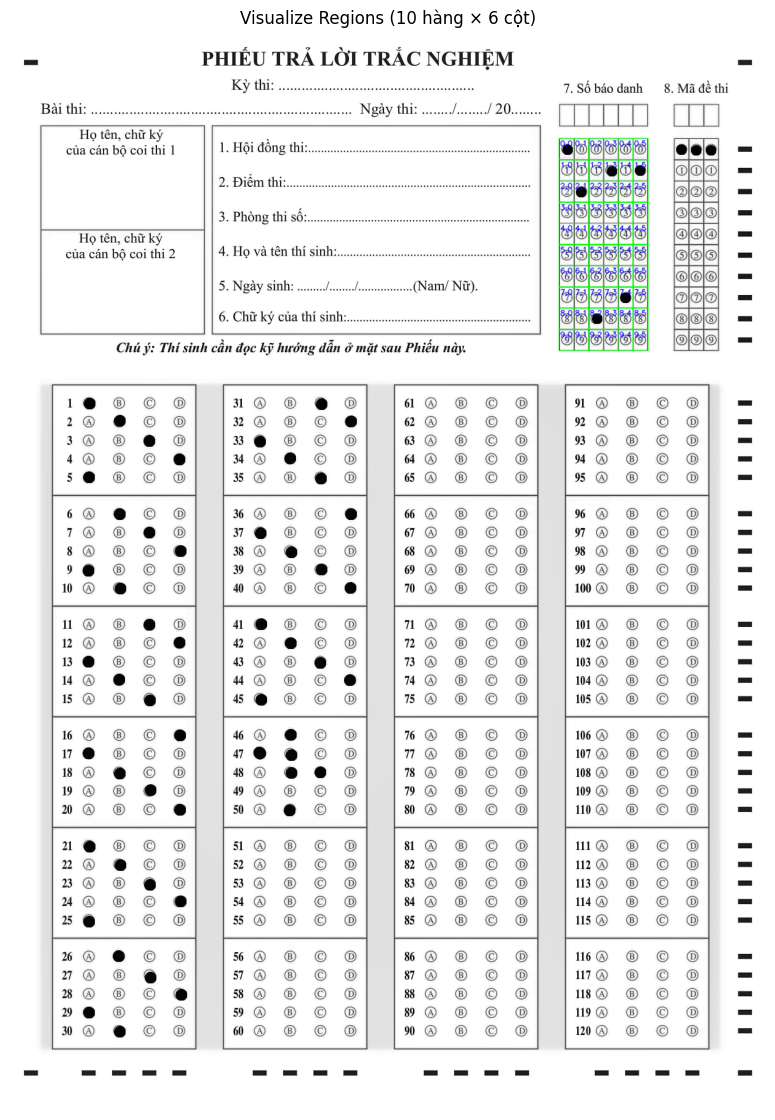

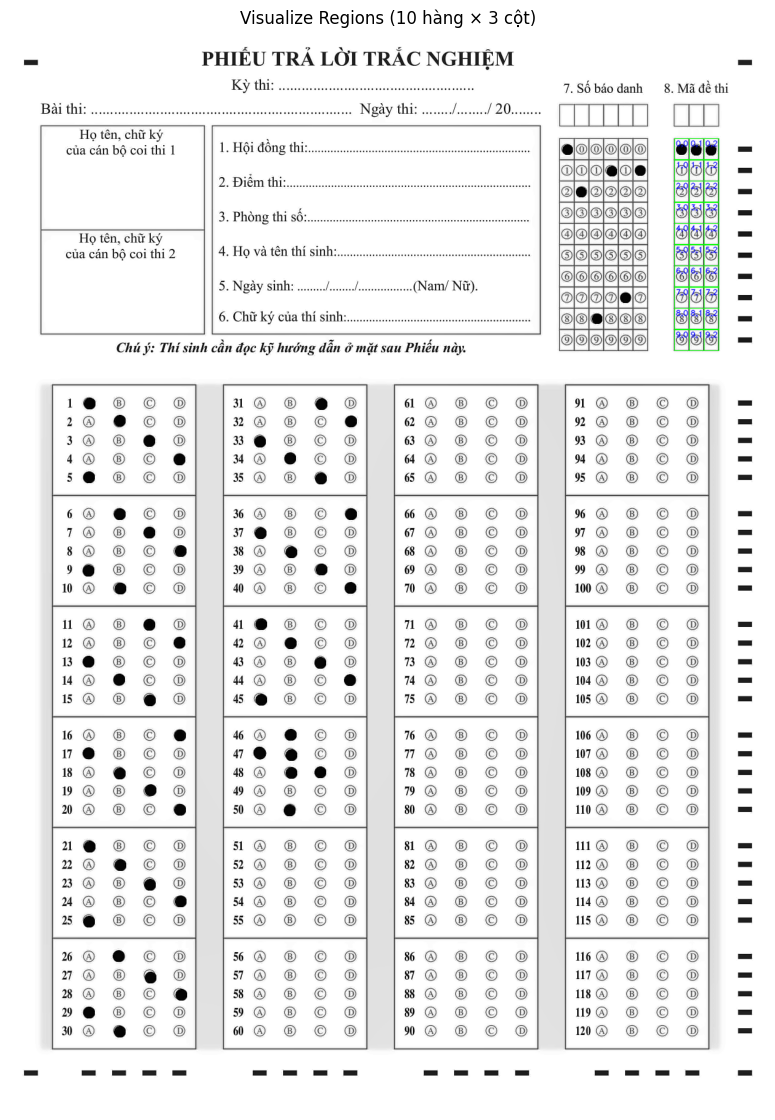

 Xử lý thành công: test2
   Mã SV: 028171
   Mã đề: 000
   Điểm: 9.4

HOÀN THÀNH XỬ LÝ
Tổng số ảnh: 1
Thành công: 1
Thất bại: 0

 Đã lưu kết quả vào: final_result.json

--- KẾT QUẢ CHI TIẾT ---

--- Chi tiết từng câu ---
Câu 1: Sinh viên chọn: A, Đáp án đúng: A, Kết quả: correct
Câu 2: Sinh viên chọn: B, Đáp án đúng: B, Kết quả: correct
Câu 3: Sinh viên chọn: C, Đáp án đúng: C, Kết quả: correct
Câu 4: Sinh viên chọn: D, Đáp án đúng: D, Kết quả: correct
Câu 5: Sinh viên chọn: A, Đáp án đúng: A, Kết quả: correct
Câu 6: Sinh viên chọn: B, Đáp án đúng: B, Kết quả: correct
Câu 7: Sinh viên chọn: C, Đáp án đúng: C, Kết quả: correct
Câu 8: Sinh viên chọn: D, Đáp án đúng: D, Kết quả: correct
Câu 9: Sinh viên chọn: A, Đáp án đúng: A, Kết quả: correct
Câu 10: Sinh viên chọn: B, Đáp án đúng: B, Kết quả: correct
Câu 11: Sinh viên chọn: C, Đáp án đúng: C, Kết quả: correct
Câu 12: Sinh viên chọn: D, Đáp án đúng: D, Kết quả: correct
Câu 13: Sinh viên chọn: A, Đáp án đúng: A, Kết quả: correct
Câu 14: 

In [38]:
# Xử lý tất cả ảnh trong imgs_to_grade
if not imgs_to_grade:
    print("\n Không có ảnh nào để xử lý!")
    print("Vui lòng upload ảnh vào thư mục Filled-temp/ trước khi chạy notebook.")
    all_results = []
else:
    print(f"\n{'='*60}")
    print(f"BẮT ĐẦU XỬ LÝ {len(imgs_to_grade)} ẢNH")
    print(f"{'='*60}")
    
    all_results = []
    for img_name, img_raw in imgs_to_grade.items():
        result = process_single_image(
            img_raw=img_raw,
            img_name=img_name,
            student_json_path=student_json_path,
            answer_json_path=answer_json_path
        )
        all_results.append(result)
    
    print(f"\n{'='*60}")
    print(f"HOÀN THÀNH XỬ LÝ")
    print(f"{'='*60}")
    print(f"Tổng số ảnh: {len(all_results)}")
    print(f"Thành công: {sum(1 for r in all_results if r.get('success', False))}")
    print(f"Thất bại: {sum(1 for r in all_results if not r.get('success', False))}")
    
    # Lưu tất cả kết quả vào file JSON
    output_data = {
        "total_images": len(all_results),
        "successful": sum(1 for r in all_results if r.get('success', False)),
        "failed": sum(1 for r in all_results if not r.get('success', False)),
        "results": all_results
    }
    
    with open("final_result.json", "w", encoding="utf-8") as f:
        json.dump(output_data, f, ensure_ascii=False, indent=4)
    
    print("\n Đã lưu kết quả vào: final_result.json")
    
    # Nếu chỉ có 1 ảnh, cũng xuất theo format cũ để tương thích
    if len(all_results) == 1 and all_results[0].get('success', False):
        final_result = all_results[0]
        print("\n--- KẾT QUẢ CHI TIẾT ---")
        print_exam_result(final_result)